## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from tensorflow.keras import datasets,layers,models

import tensorflow_datasets as tfds

## Loading Dataset

In [2]:
ds,ds_info=tfds.load('food101',shuffle_files=True, as_supervised=True,with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDX2EZS/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteDX2EZS/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Training And Validation set

In [3]:
train_ds, valid_ds=ds["train"],ds["validation"]

## Examples of images

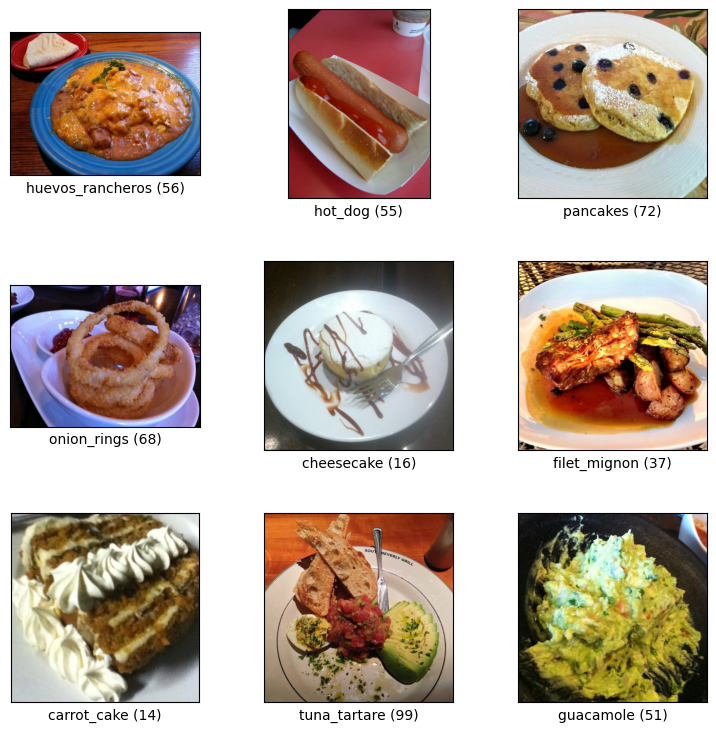

In [4]:
fig=tfds.show_examples(train_ds,ds_info)

## Image processing

In [5]:
MAX_SIDE_LEN = 128
HOT_DOG_CLASS = 55
train_ds = train_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)
valid_ds = valid_ds.map(
    lambda image, label: (tf.cast(tf.image.resize(image, [MAX_SIDE_LEN, MAX_SIDE_LEN]), dtype=tf.int32), tf.cast(label == HOT_DOG_CLASS, dtype=tf.int32))
)

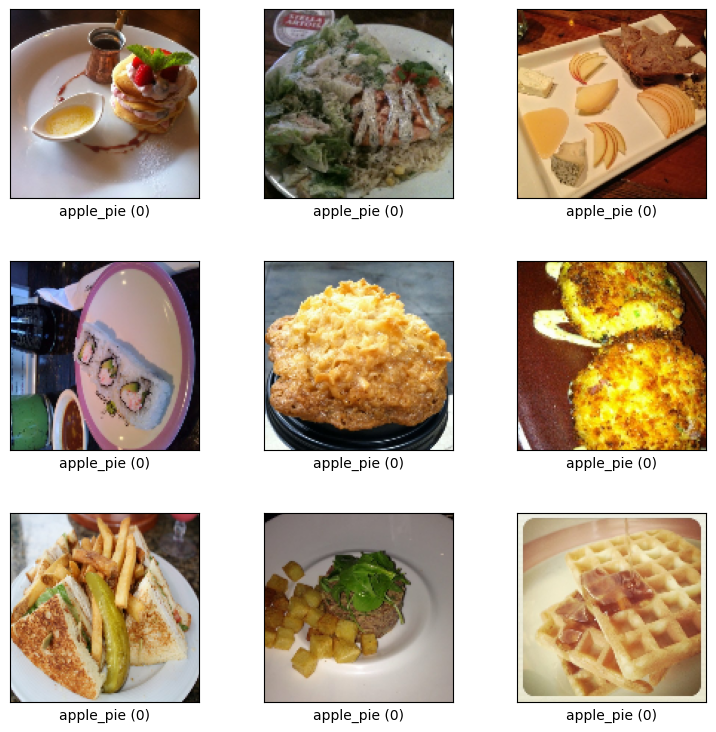

In [6]:
fig = tfds.show_examples(train_ds,ds_info)

In [7]:
train_hd_size,valid_hd_size =750,250
train_hotdogs=train_ds.filter(lambda _,label: label ==1).repeat(3)
train_nothotdogs = train_ds.filter(lambda _,label: label ==0)

In [8]:
valid_hotdogs = valid_ds.filter(lambda _, label:label == 1).repeat(3)
valid_nothotdogs = valid_ds.filter(lambda _,label: label==0)

In [9]:
valid_hotdogs

<_RepeatDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.int32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [10]:
batch_size =16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs,train_nothotdogs],weights=[0.5,0.5],stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds= tf.data.Dataset.sample_from_datasets([valid_hotdogs,valid_nothotdogs], weights=[0.5,0.5],stop_on_empty_dataset=True)
valid_ds = valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [11]:
for image, label in train_ds.take(3):
  print(image[0][0][0])
  print(label)

tf.Tensor([67 30 13], shape=(3,), dtype=int32)
tf.Tensor([0 1 0 1 1 1 0 1 1 1 1 1 0 0 1 1], shape=(16,), dtype=int32)
tf.Tensor([224 216 231], shape=(3,), dtype=int32)
tf.Tensor([1 0 0 0 1 0 0 1 1 0 0 0 1 0 0 0], shape=(16,), dtype=int32)
tf.Tensor([164 176 155], shape=(3,), dtype=int32)
tf.Tensor([0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 1], shape=(16,), dtype=int32)


## Neureal Network implementation


In [12]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2)
])

In [13]:
random.seed(0)
model=models.Sequential()
model.add(layers.Rescaling(1./225))
model.add(layers.Conv2D(128,(3,3), activation ='relu',input_shape=(MAX_SIDE_LEN, MAX_SIDE_LEN,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64,(3,3),activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1))


In [14]:
lr=0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
epochs =50
history =model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/50
284/284 [==============================] - 134s 470ms/step - loss: 1.0215 - accuracy: 0.5569 - val_loss: 0.9113 - val_accuracy: 0.6224
Epoch 2/50
284/284 [==============================] - 14s 51ms/step - loss: 0.8436 - accuracy: 0.5857 - val_loss: 0.7960 - val_accuracy: 0.6739
Epoch 3/50
284/284 [==============================] - 16s 56ms/step - loss: 0.7608 - accuracy: 0.6139 - val_loss: 0.7350 - val_accuracy: 0.6977
Epoch 4/50
284/284 [==============================] - 14s 50ms/step - loss: 0.7069 - accuracy: 0.6353 - val_loss: 0.6986 - val_accuracy: 0.7234
Epoch 5/50
284/284 [==============================] - 16s 58ms/step - loss: 0.6640 - accuracy: 0.6655 - val_loss: 0.6635 - val_accuracy: 0.7261
Epoch 6/50
284/284 [==============================] - 15s 54ms/step - loss: 0.6164 - accuracy: 0.7058 - val_loss: 0.6418 - val_accuracy: 0.7182
Epoch 7/50
284/284 [==============================] - 14s 50ms/step - loss: 0.5682 - accuracy: 0.7406 - val_loss: 0.6367 - val_accurac

In [17]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in valid_ds.take(1):
  images = image_batch
  labels =label_batch

<Figure size 1000x1000 with 0 Axes>

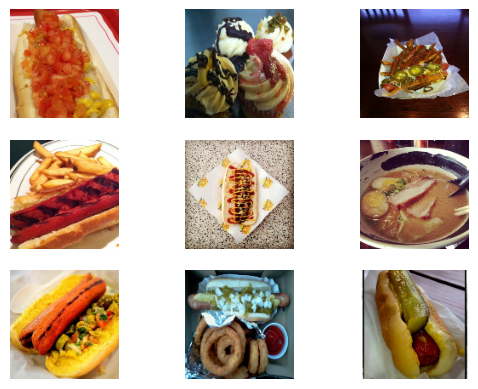

In [18]:
for i in range(9):
  ax =plt.subplot(3,3,i+1)
  plt.imshow(images[i])
  plt.axis("off")

In [19]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([1, 0, 1, 1, 1, 0, 1, 1, 1], dtype=int32)>

In [23]:
# save it as a h5 file


model.save('model_hot_dog.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
